In [9]:
from __future__ import print_function

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [61]:
# Parameters
lr = 0.1 # learning rate
epochs = 6
batch_size = 100
# calculate the number of steps based on the number of samples, batch size, and number of epochs
num_steps = len(mnist.train.images)/batch_size * epochs 

# Network Parameters
num_input = 784
num_classes = 10 

# Feature columns describe how to use the input.
feature_columns = [tf.feature_column.numeric_column("x", shape=[784])] # there is no label, so we simply use x

In [62]:
def training_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict({'x':features}), labels.astype(np.int32)))
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(70000).repeat().batch(batch_size)
    # Return the dataset.
    return dataset

In [63]:
def neural_net(features, labels, mode, params):
    #Input layer
    net = tf.feature_column.input_layer(features, params['feature_columns'])
    
    #Hidden layers
    for units in params['hidden_units']:
        net = tf.layers.dense(net, units=units, activation=tf.nn.relu)
    
    # Output layer. Compute logits (1 per class).
    logits = tf.layers.dense(net, params['n_classes'], activation=None)

    # Compute predictions.
    predicted_classes = tf.argmax(logits, 1) 
    ## If we're just querying, return 
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits),
            'logits': logits,
        }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Compute loss.
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(labels=labels,
                                   predictions=predicted_classes,
                                   name='acc_op')
    metrics = {'accuracy': accuracy}
    tf.summary.scalar('accuracy', accuracy[1])

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = tf.train.AdagradOptimizer(learning_rate=lr)
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

In [64]:
model = tf.estimator.Estimator(
    model_fn=neural_net,
    params={
        'feature_columns': feature_columns,
        'hidden_units': [512, 512],
        'n_classes': 10,
    })

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a1f3b8590>, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/2z/khrnj_dn3zv_t52wp04myk200000gn/T/tmpFoE4JV', '_save_summary_steps': 100}


In [65]:
# Train the Model.
model.train(lambda:training_input_fn(mnist.train.images,mnist.train.labels,batch_size),steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/2z/khrnj_dn3zv_t52wp04myk200000gn/T/tmpFoE4JV/model.ckpt.
INFO:tensorflow:loss = 2.282632, step = 1
INFO:tensorflow:global_step/sec: 148.704
INFO:tensorflow:loss = 0.2859108, step = 101 (0.674 sec)
INFO:tensorflow:global_step/sec: 187.92
INFO:tensorflow:loss = 0.3261734, step = 201 (0.532 sec)
INFO:tensorflow:global_step/sec: 173.332
INFO:tensorflow:loss = 0.14059903, step = 301 (0.577 sec)
INFO:tensorflow:global_step/sec: 151.296
INFO:tensorflow:loss = 0.07641499, step = 401 (0.661 sec)
INFO:tensorflow:global_step/sec: 171.676
INFO:tensorflow:loss = 0.118371524, step = 501 (0.583 sec)
INFO:tensorflow:global_step/sec: 146.414
INFO:tensorflow:loss = 0.05634487, step = 601 (0.683 sec)
INFO:tensorflow:global_step/sec: 182.518
INFO:tensorflow:loss = 0.081746906, step = 701 (0.548 sec)
INFO:tensorflow:global_step/sec: 167.241
INFO:tensorflow:loss = 0.04350826, step = 801 (0.598 sec)
INFO:t

In [66]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
 
    features=dict({'x':features})
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels.astype(np.int32))

    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the dataset.
    return dataset

In [67]:
eval_result = model.evaluate(
    input_fn=lambda:eval_input_fn(mnist.test.images,mnist.test.labels,batch_size))

acc=eval_result["accuracy"]
print('\nTest set accuracy: {0:0.2f}%\n'.format(acc*100))

INFO:tensorflow:Starting evaluation at 2018-03-24-15:15:46
INFO:tensorflow:Restoring parameters from /var/folders/2z/khrnj_dn3zv_t52wp04myk200000gn/T/tmpFoE4JV/model.ckpt-3300
INFO:tensorflow:Finished evaluation at 2018-03-24-15:15:47
INFO:tensorflow:Saving dict for global step 3300: accuracy = 0.9802, global_step = 3300, loss = 0.06101506

Test set accuracy: 98.02%



INFO:tensorflow:Restoring parameters from /var/folders/2z/khrnj_dn3zv_t52wp04myk200000gn/T/tmpFoE4JV/model.ckpt-3300


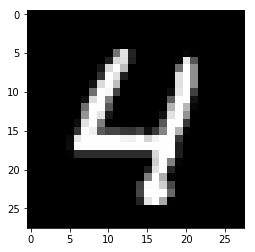

Model prediction: 4
Actual Label: 4


In [68]:
# Predict single image

whichImage = random.randint(0,len(mnist.test.images))
# Get image from test set
test_image = mnist.test.images[whichImage].reshape(1, 784)

preds = list(model.predict(input_fn=lambda:eval_input_fn(test_image,None,1)))

# Display
plt.imshow(np.reshape(test_image, [28, 28]), cmap='gray')
plt.show()
print("Model prediction:", preds[0]['class_ids'][0])
print("Actual Label:",mnist.test.labels[whichImage])